# Temperature Forecast for Berlin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Autoregression model

In [268]:
train_data = pickle.load(open('data_train.pkl', 'rb'))
train_data = train_data.drop(['random', 'trend', 'month'], axis=1)
train_data

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,,,,
1979-01-01,-1.19,1,0,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.019755,-1.170245
1979-01-02,-0.93,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.019948,-0.910052
1979-01-03,-0.78,3,2,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020141,-0.759859
1979-01-04,-0.96,4,3,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020334,-0.939666
1979-01-05,-0.99,5,4,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020527,-0.969473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,0.13,28,14971,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309872,-0.179872
2019-12-29,0.00,29,14972,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309679,-0.309679
2019-12-30,0.45,30,14973,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309486,0.140514



## Adding lags
Since remainder appears to be a stationary time series with values at different time instants that seem correlated, we introduced a lag feature of the remainder.

We add it now to our model because we want better predictions for the main target temperature.

In [269]:
train_data['lag1'] = train_data['remainder'].shift(1)
train_data.dropna(inplace=True)
train_data.head()
train_data.copy()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,,,,
1979-01-02,-0.93,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.019948,-0.910052,-1.170245
1979-01-03,-0.78,3,2,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020141,-0.759859,-0.910052
1979-01-04,-0.96,4,3,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020334,-0.939666,-0.759859
1979-01-05,-0.99,5,4,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020527,-0.969473,-0.939666
1979-01-06,-1.27,6,5,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020720,-1.249280,-0.969473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,0.13,28,14971,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309872,-0.179872,-0.000065
2019-12-29,0.00,29,14972,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309679,-0.309679,-0.179872
2019-12-30,0.45,30,14973,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309486,0.140514,-0.309679


In [270]:
X = train_data.drop(['temperature', 'trend_seasonal', 'remainder'], axis=1)
y = train_data[['temperature']]

lag_1 = LinearRegression()

### Train model and train predictions

In [277]:
lag_1.fit(X,y)

train_data['predictions_lag_1'] = lag_1.predict(X)
train_data.head()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,predictions_lag_1
DATE,,,,,,,,,,,,,,,,,,,,
1979-01-02,-0.93,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.019948,-0.910052,-1.170245,-0.960609
1979-01-03,-0.78,3,2,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020141,-0.759859,-0.910052,-0.750566
1979-01-04,-0.96,4,3,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020334,-0.939666,-0.759859,-0.629355
1979-01-05,-0.99,5,4,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020527,-0.969473,-0.939666,-0.774642
1979-01-06,-1.27,6,5,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020720,-1.249280,-0.969473,-0.798794


In [278]:
def plot_timeseries (df, title=" ", ylim=True):
    
    df.plot()
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("Temperature")
    plt.show()

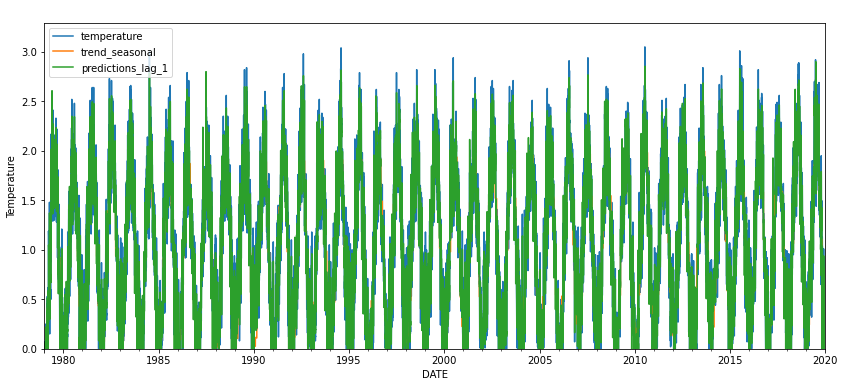

In [279]:
plot_timeseries(train_data[['temperature', 'trend_seasonal', 'predictions_lag_1']])

In [280]:
train_data_2015 = train_data[train_data["year"] == 2014]

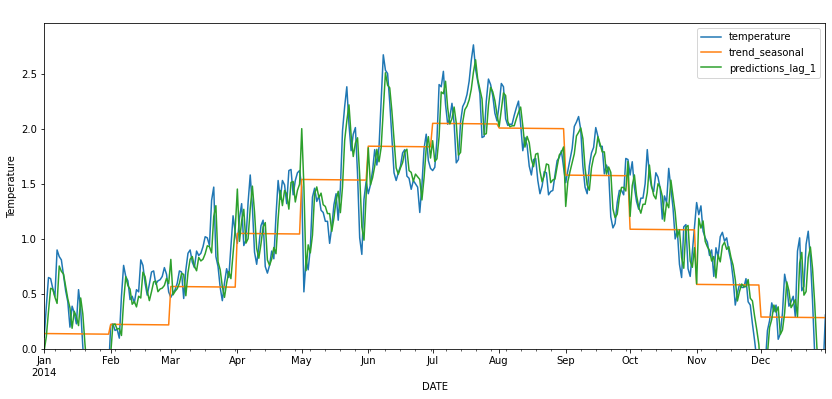

In [281]:
plot_timeseries(train_data_2015[['temperature', 'trend_seasonal', 'predictions_lag_1']])

<b> Calculate the correlation between them </b>


3. Calculate the correlation coefficient between the time-lagged and the original remainder

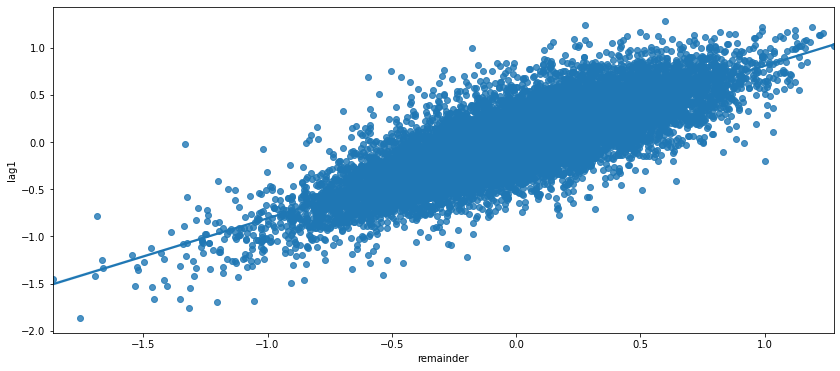

In [283]:
sns.regplot(x = train_data['remainder'], y = train_data['lag1'], fit_reg=True, scatter=True);

In [284]:
train_data[['remainder', 'lag1']].corr()

,remainder,lag1
remainder,1.000000,0.808213
lag1,0.808213,1.000000


In [285]:
train_data

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,predictions_lag_1
DATE,,,,,,,,,,,,,,,,,,,,
1979-01-02,-0.93,2,1,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.019948,-0.910052,-1.170245,-0.960609
1979-01-03,-0.78,3,2,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020141,-0.759859,-0.910052,-0.750566
1979-01-04,-0.96,4,3,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020334,-0.939666,-0.759859,-0.629355
1979-01-05,-0.99,5,4,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020527,-0.969473,-0.939666,-0.774642
1979-01-06,-1.27,6,5,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020720,-1.249280,-0.969473,-0.798794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,0.13,28,14971,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309872,-0.179872,-0.000065,0.321158
2019-12-29,0.00,29,14972,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309679,-0.309679,-0.179872,0.175871
2019-12-30,0.45,30,14973,2019,0,0,1,0,0,0,0,0,0,0,0,0,0.309486,0.140514,-0.309679,0.070962


#### Find how many lags are needed.

1st method applied, plot the Partial Autocorrelation between different lags.

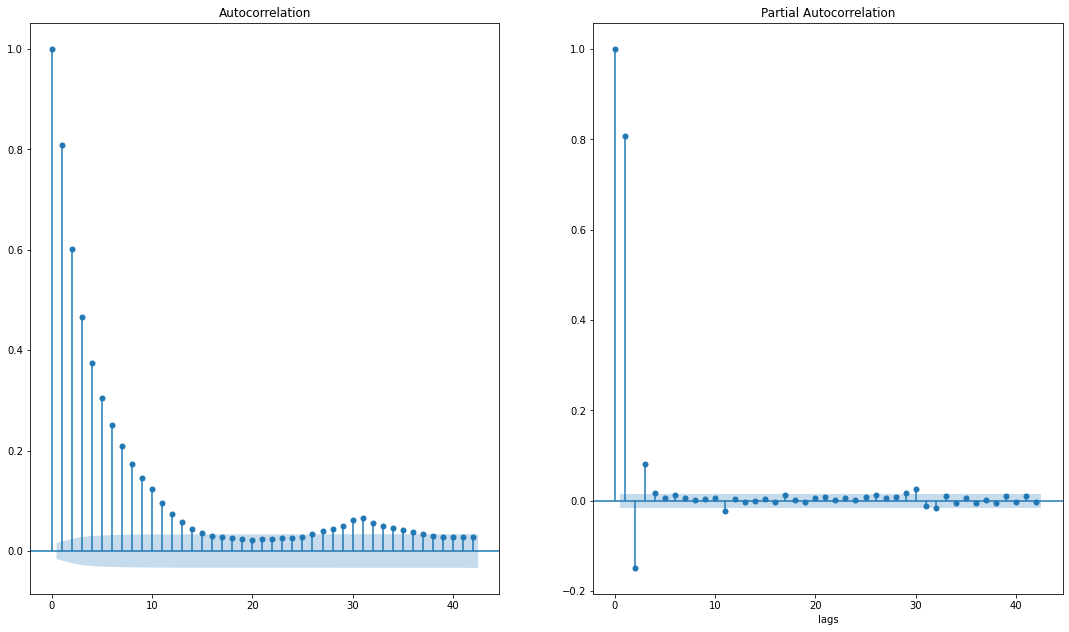

In [286]:
fig,(ax_acf,ax_pcf) = plt.subplots(ncols=2)
fig.set_size_inches(18.5, 10.5)


plot_acf(train_data['remainder'],ax=ax_acf)
plot_pacf(train_data['remainder'],ax=ax_pcf)

plt.xlabel('lags');

A slow decrease at the ACF and a sudden cut of at PCF indicate that 3 lags are suggested for our model.

###### 2nd method



In [287]:
selected_order = ar_select_order(train_data['remainder'], maxlag = 7)
selected_order.ar_lags

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


array([1, 2, 3])

In [288]:
stats_ar1 = AutoReg(train_data['remainder'], lags=1).fit()

stats_ar1.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                14975
Model:                     AutoReg(1)   Log Likelihood                 568.947
Method:               Conditional MLE   S.D. of innovations              0.233
Date:                Sat, 03 Jul 2021   AIC                             -2.913
Time:                        16:47:19   BIC                             -2.912
Sample:                    01-03-1979   HQIC                            -2.913
                         - 01-01-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     8.119e-05      0.002      0.043      0.966      -0.004       0.004
remainder.L1     0.8080      0.005    167.897      0.000       0.799       0.817
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2376           +0.0000j            1.2376            0.0000
-----------------------------------------------------------------------------
"""

In [289]:
stats_ar1.predict()

1979-01-02         NaN
1979-01-03   -0.735237
1979-01-04   -0.613881
1979-01-05   -0.759165
1979-01-06   -0.783249
                ...   
2019-12-28    0.000029
2019-12-29   -0.145255
2019-12-30   -0.250138
2019-12-31    0.113616
2020-01-01    0.234971
Freq: D, Length: 14975, dtype: float64

### Adjust 2 more lags to the data to start forcasting!

Do as above for lag1!

In [290]:
train_data['lag2'] = train_data['remainder'].shift(2)
train_data['lag3'] = train_data['remainder'].shift(3)
train_data.dropna(inplace=True)
train_data = train_data.drop(['predictions_lag_1'], axis=1)
train_data.head()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
1979-01-05,-0.99,5,4,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020527,-0.969473,-0.939666,-0.759859,-0.910052
1979-01-06,-1.27,6,5,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020720,-1.249280,-0.969473,-0.939666,-0.759859
1979-01-07,-0.54,7,6,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020913,-0.519087,-1.249280,-0.969473,-0.939666
1979-01-08,0.05,8,7,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.021106,0.071106,-0.519087,-1.249280,-0.969473
1979-01-09,0.06,9,8,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.021299,0.081299,0.071106,-0.519087,-1.249280



# Train the full linear auto-regression model on the training data

Trend_seasonal and noise gave us the information needed, so we drop them!

In [291]:
X = train_data.drop(['temperature', 'trend_seasonal', 'remainder'], axis=1)
y = train_data['temperature']

m_full = LinearRegression()

We add the full predictions on our data, since its one more feature needed for the forecasting.

In [292]:
m_full.fit(X,y)

train_data['predictions_full'] = m_full.predict(X)
train_data.head()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
DATE,,,,,,,,,,,,,,,,,,,,,,
1979-01-05,-0.99,5,4,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020527,-0.969473,-0.939666,-0.759859,-0.910052,-0.802344
1979-01-06,-1.27,6,5,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020720,-1.249280,-0.969473,-0.939666,-0.759859,-0.777904
1979-01-07,-0.54,7,6,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.020913,-0.519087,-1.249280,-0.969473,-0.939666,-1.048885
1979-01-08,0.05,8,7,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.021106,0.071106,-0.519087,-1.249280,-0.969473,-0.302669
1979-01-09,0.06,9,8,1979,0,0,0,0,1,0,0,0,0,0,0,0,-0.021299,0.081299,0.071106,-0.519087,-1.249280,0.065210


Are the different models anyway close? 

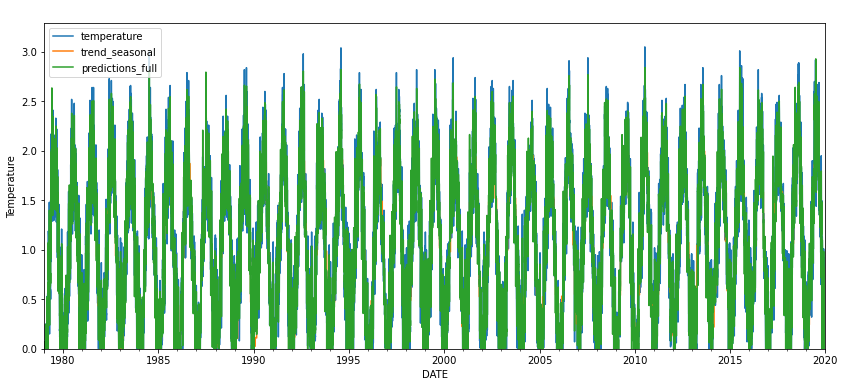

In [293]:
plot_timeseries(train_data[['temperature', 'trend_seasonal', 'predictions_full']])

Try for a smaller time interval

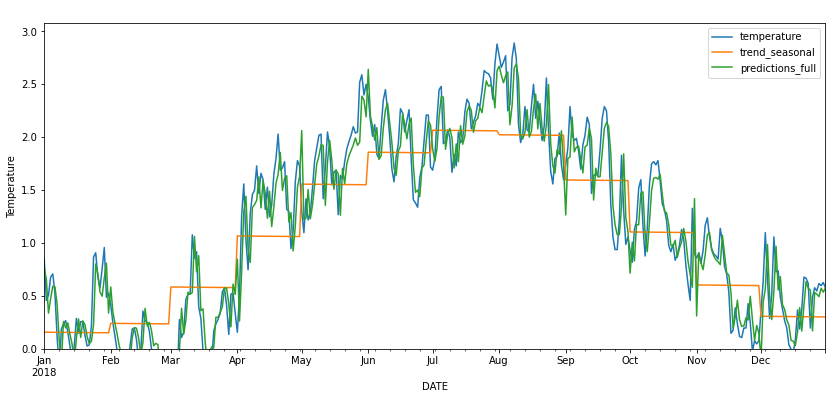

In [294]:
train_data_2018 = train_data[train_data["year"] == 2018]
plot_timeseries(train_data_2018[['temperature', 'trend_seasonal', 'predictions_full']])

In [296]:
# extracting full model coefficients. These i need to compare with the last model, withthe test data.

pd.DataFrame(m_full.coef_.reshape(1,18), columns=X.columns)

,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,0.015068,-0.015181,5.549439,-1.190417,1.609909,1.759364,-2.911545,-3.465972,1.18907,0.522242,-2.13985,-0.24991,1.5949,1.623462,1.658748,0.939525,-0.224172,0.081557


# Cross validation for time series

Create a TimeSeriesSplit object

In [199]:
splits_ts = TimeSeriesSplit(n_splits=5)

time_cv = splits_ts.split(X, y)

for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))

The training data for iteration #1 are the observations steps  = [   0    1    2 ... 2494 2495 2496]
size of training data = 2497
The validation data for iteration #1 are the observations steps = [2497 2498 2499 ... 4989 4990 4991]
size of validation data = 2495
The training data for iteration #2 are the observations steps  = [   0    1    2 ... 4989 4990 4991]
size of training data = 4992
The validation data for iteration #2 are the observations steps = [4992 4993 4994 ... 7484 7485 7486]
size of validation data = 2495
The training data for iteration #3 are the observations steps  = [   0    1    2 ... 7484 7485 7486]
size of training data = 7487
The validation data for iteration #3 are the observations steps = [7487 7488 7489 ... 9979 9980 9981]
size of validation data = 2495
The training data for iteration #4 are the observations steps  = [   0    1    2 ... 9979 9980 9981]
size of training data = 9982
The validation data for iteration #4 are the observations steps = [ 9982  9983  9

In [200]:
time_cv = splits_ts.split(X, y)

estimator = LinearRegression()

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.90245511 0.90218145 0.92374722 0.92227823 0.91860432]
0.9138532664832235


# Evaluation metrics

#### Mean Absolute Percentage Error

In the above cases the underlying ball park of where the data is not understood from the error measure itself. This is where mean absolute percentage error comes in as this is a percentage error and hence gives a good idea of the relative error. 

In [201]:
y_pred = train_data['predictions_full']

def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean() 

mape_vectorized_v2(y, y_pred )


0.20150314243506107

<b> Residuals </b>


<AxesSubplot:xlabel='predictions_full'>

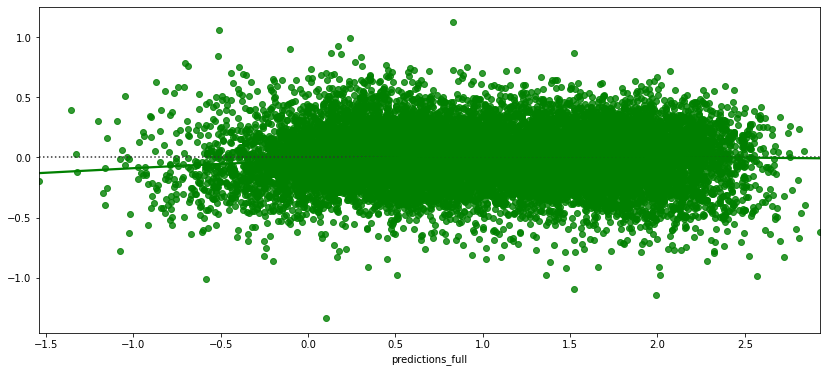

In [202]:
residuals = y - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g")

## Use trained full model to predict temperature

### Apply same steps to test data.

<b> Calculate first lag1 for test_data </b>

In [203]:
test_data = pickle.load(open('data_test.pkl', 'rb'))
test_data = test_data.drop(['month'], axis=1)
test_data[:10]

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,,,,
2020-01-02,0.09,2,14976,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169606,-0.079606
2020-01-03,0.46,3,14977,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169413,0.290587
2020-01-04,0.42,4,14978,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169220,0.250780
2020-01-05,0.18,5,14979,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169028,0.010972
2020-01-06,0.49,6,14980,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168835,0.321165
2020-01-07,0.27,7,14981,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168642,0.101358
2020-01-08,0.64,8,14982,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168449,0.471551
2020-01-09,0.84,9,14983,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168256,0.671744
2020-01-10,0.94,10,14984,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168063,0.771937


Add here also 3 lags!

In [204]:
test_data['lag1'] = test_data['remainder'].shift(1)
test_data['lag2'] = test_data['remainder'].shift(2)
test_data['lag3'] = test_data['remainder'].shift(3)
test_data.head()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.09,2,14976,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169606,-0.079606,NaN,NaN,NaN
2020-01-03,0.46,3,14977,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169413,0.290587,-0.079606,NaN,NaN
2020-01-04,0.42,4,14978,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169220,0.250780,0.290587,-0.079606,NaN
2020-01-05,0.18,5,14979,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169028,0.010972,0.250780,0.290587,-0.079606
2020-01-06,0.49,6,14980,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168835,0.321165,0.010972,0.250780,0.290587


#### NaN values should be correctly handled. 

#### Look at the last days!!! Have to be the correct  remainder values from previous days as well as the values of the previous lags!
The more the lags the more the days go back!
Values taken from lags have to be the one before. 

In [205]:
#Filled with previous date remainder.
test_data.loc['2020-01-02', 'lag1'] = train_data.loc['2020-01-01', 'remainder']
test_data.loc['2020-01-03', 'lag2'] = train_data.loc['2020-01-01', 'remainder']
test_data.loc['2020-01-04', 'lag3'] = train_data.loc['2020-01-01', 'remainder']

test_data.loc['2020-01-02', 'lag2'] = train_data.loc['2020-01-01', 'lag1']

test_data.loc['2020-01-03', 'lag3'] = train_data.loc['2020-01-01','lag1']

test_data.loc['2020-01-02', 'lag3'] = train_data.loc['2020-01-01', 'lag2']

test_data.head()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.09,2,14976,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169606,-0.079606,0.100201,0.290707,0.140514
2020-01-03,0.46,3,14977,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169413,0.290587,-0.079606,0.100201,0.290707
2020-01-04,0.42,4,14978,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169220,0.250780,0.290587,-0.079606,0.100201
2020-01-05,0.18,5,14979,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169028,0.010972,0.250780,0.290587,-0.079606
2020-01-06,0.49,6,14980,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168835,0.321165,0.010972,0.250780,0.290587


In [206]:
test_data.columns

Index(['temperature', 'day', 'timestep', 'year', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September', 'trend_seasonal', 'remainder', 'lag1', 'lag2', 'lag3'], dtype='object')

In [207]:
train_data.columns

Index(['temperature', 'day', 'timestep', 'year', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September', 'trend_seasonal', 'remainder', 'lag1', 'lag2', 'lag3', 'predictions_full'], dtype='object')

## Make full model predictions

Be sure test and train data had the same EDA and FE.

In [208]:
X_test = test_data.drop(['temperature', 'trend_seasonal', 'remainder'], axis=1)
test_data['predictions_full'] = m_full.predict(X_test)

test_data.head()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
DATE,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.09,2,14976,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169606,-0.079606,0.100201,0.290707,0.140514,0.217616
2020-01-03,0.46,3,14977,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169413,0.290587,-0.079606,0.100201,0.290707,0.103525
2020-01-04,0.42,4,14978,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169220,0.250780,0.290587,-0.079606,0.100201,0.475989
2020-01-05,0.18,5,14979,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.169028,0.010972,0.250780,0.290587,-0.079606,0.340825
2020-01-06,0.49,6,14980,2020,0,0,0,0,1,0,0,0,0,0,0,0,0.168835,0.321165,0.010972,0.250780,0.290587,0.154523


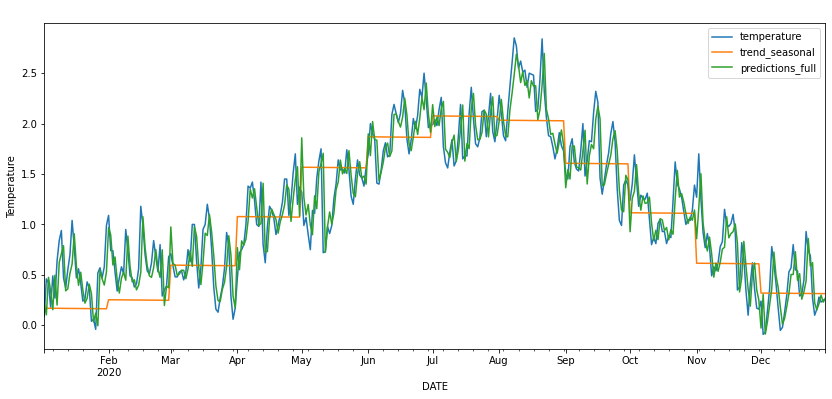

In [209]:
plot_timeseries(test_data[['temperature', 'trend_seasonal', 'predictions_full']], ylim=False)

Seems many trial errors -mostly resulting to errors- to finally to look good!

### Evaluation metrics! 
##### R squarred, RMSE, MSE

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

##### Train Data

In [223]:
y_true = train_data['temperature']
y_pred_tr_seas = train_data['trend_seasonal']
y_pred_pr_full = train_data['predictions_full']

In [226]:
print ('MSE for train data with trend_seasonal: ', mean_squared_error(y_true, y_pred_tr_seas))
       
print ('MSE for train data with full predictions: ', mean_squared_error(y_true, y_pred_pr_full))
       
print ('RMSE for train data with trend_seasonal:', rmse(y_true, y_pred_tr_seas))
print ('RMSE for train data with trend_seasonal:', rmse(y_true, y_pred_pr_full))

print('R_2 score for train data with trend_seasonal:',r2_score(y_true, y_pred_tr_seas))
print('R_2 score for train data with full predictions:',r2_score(y_true, y_pred_pr_full))

MSE for train data with trend_seasonal:  0.15634633101594952
MSE for train data with full predictions:  0.052685285690281906
RMSE for train data with trend_seasonal: 0.39540653891400185
RMSE for train data with trend_seasonal: 0.2295327551576935
R_2 score for train data with trend_seasonal: 0.7490058787853555
R_2 score for train data with full predictions: 0.9154204841466617


##### Test Data

In [220]:
y_true = test_data['temperature']
y_pred_tr_seas = test_data['trend_seasonal']
y_pred_pr_full = test_data['predictions_full']

In [222]:
print ('MSE for test data with trend_seasonal: ', mean_squared_error(y_true, y_pred_tr_seas))
       
print ('MSE for test data with full predictions: ', mean_squared_error(y_true, y_pred_pr_full))
       
print ('RMSE for test data with trend_seasonal:', rmse(y_true, y_pred_tr_seas))
print ('RMSE for test data with trend_seasonal:', rmse(y_true, y_pred_pr_full))

print('R_2 score for test data with trend_seasonal:',r2_score(y_true, y_pred_tr_seas))
print('R_2 score for test data with full predictions:',r2_score(y_true, y_pred_pr_full))

MSE for test data with trend_seasonal:  0.11422242782418099
MSE for test data with full predictions:  0.046167979089330825
RMSE for test data with trend_seasonal: 0.3379680869907409
RMSE for test data with trend_seasonal: 0.2148673523114456
R_2 score for test data with trend_seasonal: 0.7509408066475386
R_2 score for test data with full predictions: 0.899331857589287


## Final Step! Generate short term predictions
#### Retrain my model on the whole data

In [225]:
data = train_data.append(test_data)
data.tail()

,temperature,day,timestep,year,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
DATE,,,,,,,,,,,,,,,,,,,,,,
2020-12-27,0.16,27,15336,2020,0,0,1,0,0,0,0,0,0,0,0,0,0.314698,-0.154698,-0.214891,-0.045084,0.374723,0.152858
2020-12-28,0.28,28,15337,2020,0,0,1,0,0,0,0,0,0,0,0,0,0.314505,-0.034505,-0.154698,-0.214891,-0.045084,0.213126
2020-12-29,0.23,29,15338,2020,0,0,1,0,0,0,0,0,0,0,0,0,0.314312,-0.084312,-0.034505,-0.154698,-0.214891,0.298595
2020-12-30,0.25,30,15339,2020,0,0,1,0,0,0,0,0,0,0,0,0,0.314119,-0.064119,-0.084312,-0.034505,-0.154698,0.229652
2020-12-31,0.26,31,15340,2020,0,0,1,0,0,0,0,0,0,0,0,0,0.313926,-0.053926,-0.064119,-0.084312,-0.034505,0.269479


In [227]:
data.isna().sum()

temperature         0
day                 0
timestep            0
year                0
April               0
August              0
December            0
February            0
January             0
July                0
June                0
March               0
May                 0
November            0
October             0
September           0
trend_seasonal      0
remainder           0
lag1                0
lag2                0
lag3                0
predictions_full    0
dtype: int64

In [247]:
X = data.drop(columns=['temperature', 'trend_seasonal', 'remainder', 'predictions_full', 'day', 'year'])
y = data['temperature']

m_full_combined = LinearRegression()
m_full_combined.fit(X, y)

LinearRegression()

## Generate predictions for a future time

In [248]:
data.index.max()

Timestamp('2020-12-31 00:00:00')

In [249]:
# so we need to generate features for the time point 2021-01-01
X_future = []

timestep = data['timestep'].max() + 1
months = [0]*4 + [1] + [0]*7   #dummy code for Jan
lag1 = data.loc['2020-12-31', 'remainder'] # taking the last remainder 
lag2 = data.loc['2020-12-31', 'lag1'] # taking the last lag!!!
lag3 = data.loc['2020-12-31', 'lag2'] # taking the last lag!!!

print(timestep, months, lag1, lag2, lag3)

15341 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] -0.05392593276455604 -0.06411887811698047 -0.08431182346940486


In [250]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)


In [251]:
X_future

[15341,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.05392593276455604,
 -0.06411887811698047,
 -0.08431182346940486]

In [252]:
X_future = pd.DataFrame([X_future])
X_future.columns = X.columns

X_future

,timestep,April,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,15341,0,0,0,0,1,0,0,0,0,0,0,0,-0.053926,-0.064119,-0.084312


In [253]:
print("Prediction for 2021-01-01 is {}".format(m_full_combined.predict(X_future)[0]))

Prediction for 2021-01-01 is 0.13412939672292634


In [254]:
m_full_combined.coef_

array([ 1.27415384e-05, -2.83788011e-02,  9.18588062e-01, -7.86289866e-01,
       -8.48328310e-01, -9.31704946e-01,  9.66920688e-01,  7.57385295e-01,
       -5.08067054e-01,  4.54205987e-01, -4.94977291e-01,  4.87085624e-03,
        4.95775380e-01,  9.40009066e-01, -2.25927395e-01,  8.24840824e-02])

In [301]:
pd.DataFrame(m_full_combined.coef_.reshape(1,16), columns=X_future.columns)

,timestep,April,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,0.000013,-0.028379,0.918588,-0.78629,-0.848328,-0.931705,0.966921,0.757385,-0.508067,0.454206,-0.494977,0.004871,0.495775,0.940009,-0.225927,0.082484


### Compare with previous day

In [304]:
previous_day = test_data.loc['2020-12-31']['temperature']
previous_day

0.26